# Module 11 - Signal interactions
----------------------------------------------

# Goals
-----------

- Compute the Power Spectrum Density (PSD) and coherence between two signals


# Coherence
-----------------

Let's start by considering how two oscillating signals may be related. 
There are various possible relationships between the two, such as illustrated here 
(from [Siegel et al. 2012](http://www.ncbi.nlm.nih.gov/pubmed/22233726)):

<img src="11-coherence.png" style="width: 700px;">

# Coherence within the ventral striatum (vStr) and between vStr and hippocampus (hipp)
-------------------------------------------------------------------------------------------------------------

In [43]:
# Import necessary packages
%matplotlib inline
import os
import sys
import numpy as np
import nept
import matplotlib.pyplot as plt
import matplotlib.mlab
import scipy.signal

# Define where your data folder is located
data_path = os.path.join(os.path.abspath('.'), 'data')
data_folder = os.path.join(data_path, 'R016-2012-10-03')

In [2]:
# Load the info file, which contains experiment-specific information
sys.path.append(data_folder)
import r016d3 as info

In [3]:
# Load both LFPs (.ncs) from rat ventral striatum and one from the hippocampus
lfp_vstr1 = nept.load_lfp(os.path.join(data_folder, info.lfp_gamma_filename1))
lfp_vstr2 = nept.load_lfp(os.path.join(data_folder, info.lfp_gamma_filename2))

lfp_hipp = nept.load_lfp(os.path.join(data_folder, info.lfp_theta_filename))

In [4]:
# Let's restrict our LFPs to during task times
task_start = info.task_times['task-value'].start
task_stop = info.task_times['task-reward'].stop

lfp_vstr1 = lfp_vstr1.time_slice(task_start, task_stop)
lfp_vstr2 = lfp_vstr2.time_slice(task_start, task_stop)
lfp_hipp = lfp_hipp.time_slice(task_start, task_stop)

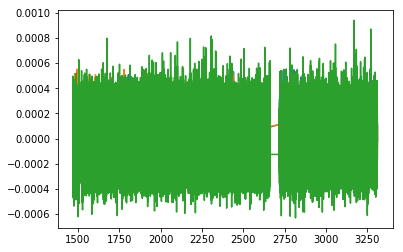

In [5]:
# Plot the LFPs. Notice the break in LFP when the task was switched from 'value' to 'reward'
plt.plot(lfp_vstr1.time, lfp_vstr1.data)
plt.plot(lfp_vstr2.time, lfp_vstr2.data)
plt.plot(lfp_hipp.time, lfp_hipp.data)
plt.show()

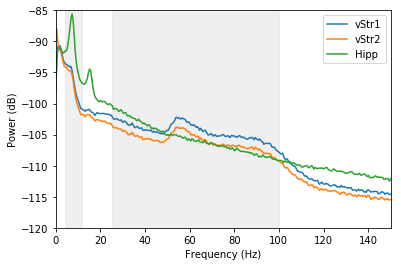

In [6]:
# Compute the Power Spectral Density (PSD) for each signal with Welch’s average
window = 2048
fs = 2000

vstr1 = np.squeeze(lfp_vstr1.data)
vstr2 = np.squeeze(lfp_vstr2.data)
hipp = np.squeeze(lfp_hipp.data)

fig, ax = plt.subplots()

# Theta
ax.axvspan(4, 12, color='#cccccc', alpha=0.3)
# Gamma
ax.axvspan(25, 100, color='#cccccc', alpha=0.3)

for lfp_data in [vstr1, vstr2, hipp]:
    power, freq = matplotlib.mlab.psd(lfp_data, 
                                      Fs=fs,
                                      NFFT=int(window*2),
                                      noverlap=int(window/2))

    power_db = 10*np.log10(power)
    plt.plot(freq, power_db)
    
    plt.xlim(0, 150)
    plt.ylim(-120, -85)
    plt.ylabel('Power (dB)')
    plt.xlabel('Frequency (Hz)')
    plt.legend(['vStr1', 'vStr2', 'Hipp'])
    
plt.show()

Notice the hippocampus has a clear theta (4 - 12 Hz) peak, 
which is visible as only a slight hump in ventral striatum. 
Ventral striatum has large gamma (25 - 100 Hz) components,
which are not present in the hippocampus.

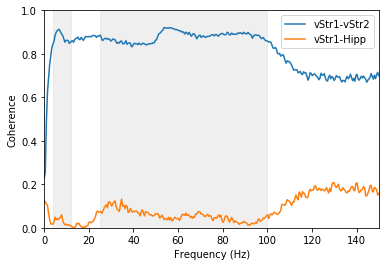

In [7]:
# Compute the coherence for vStr-vStr and vStr-hipp

fig, ax = plt.subplots()

# Theta
ax.axvspan(4, 12, color='#cccccc', alpha=0.3)
# Gamma
ax.axvspan(25, 100, color='#cccccc', alpha=0.3)

for lfp_data in [vstr2, hipp]:
    (coherence, freq) = matplotlib.mlab.cohere(vstr1, lfp_data, Fs=fs, 
                                               NFFT=int(window*2), 
                                               noverlap=int(window/2))

    plt.plot(freq, coherence)
    plt.xlim(0, 150)
    plt.ylim(0, 1)
    plt.ylabel('Coherence')
    plt.xlabel('Frequency (Hz)')
    plt.legend(['vStr1-vStr2', 'vStr1-Hipp'])
plt.show()

The coherence between the two ventral striatum signals is high overall 
compared to that between the ventral striatum and hippocampus.
The ventral striatum gamma frequencies are particularly coherent within the ventral striatum. 

# Compute vStr-Hipp coherence between experimental conditions

In [8]:
# Load events from this experiment
events = nept.load_events(os.path.join(data_folder, info.event_filename), info.event_labels)

Let's see if there is a change in coherence between _approach to the reward site_
and _reward receipt_. 

In [9]:
# Get the photobeam break times
pb = np.sort(np.append(events['feeder0'], events['feeder1']))

In [37]:
def perievent_slice(analogsignal, events, t_before, t_after, dt=None):
    """Slices the analogsignal data into perievent chunks.
    Unlike time_slice, the resulting AnalogSignal will be multidimensional.
    Only works for 1D signals.
    
    Parameters
    ----------
    analogsignal : nept.AnalogSignal
    events : np.array
    t_before : float
    t_after : float
    dt : float
    
    Returns
    -------
    nept.AnalogSignal
    
    """
    
    if analogsignal.dimensions != 1:
        raise ValueError("AnalogSignal must be 1D.")
    
    if dt is None:
        dt = np.median(np.diff(analogsignal.time))
        
    time = np.arange(-t_before, t_after+dt, dt)
    
    data = np.zeros((len(time), len(events)))
    for i, event in enumerate(events):
        sliced = analogsignal.time_slice(event-t_before, event+t_after)
        data[:,i] = np.interp(time+event, sliced.time, np.squeeze(sliced.data))
    
    return nept.AnalogSignal(data, time)

In [64]:
# Compute the perievent slices for the nosepoke times
np_vstr1 = perievent_slice(lfp_vstr1, pb, t_before=2.5, t_after=5.0)
np_vstr2 = perievent_slice(lfp_vstr2, pb, t_before=2.5, t_after=5.0)
np_hipp = perievent_slice(lfp_hipp, pb, t_before=2.5, t_after=5.0)

In [78]:
def mean_psd(perievent_lfps, window, fs):
    power = np.zeros((window+1, perievent_lfps.dimensions))
    for i, lfp in enumerate(perievent_lfps.data.T):
        power[:,i], freq = matplotlib.mlab.psd(
            lfp, Fs=fs, NFFT=int(window*2), noverlap=int(window/2))
    
    return freq, np.mean(power, axis=1)

In [83]:
def power_in_db(power):
    return 10*np.log10(power)

In [81]:
freq, power_vstr1 = mean_psd(np_vstr1, window, fs)
freq, power_vstr2 = mean_psd(np_vstr2, window, fs)
freq, power_hipp = mean_psd(np_hipp, window, fs)

(-110, -80)

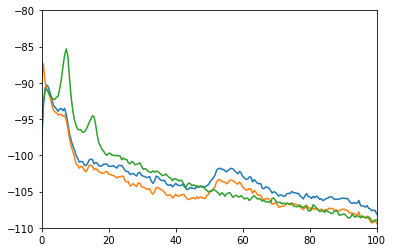

In [101]:
plt.plot(freq, power_in_db(power_vstr1))
plt.plot(freq, power_in_db(power_vstr2))
plt.plot(freq, power_in_db(power_hipp))
plt.xlim(0, 100)
plt.ylim(-110, -80)

In [114]:
def mean_csd(perievent_lfp1, perievent_lfp2, window, fs):
    freq, power = scipy.signal.csd(perievent_lfp1.data.T, perievent_lfp2.data.T, 
                                   fs=fs, nperseg=window, nfft=int(window*2))
    
    return freq, np.mean(power, axis=0)

In [115]:
freq, csd_vstr1_vstr2 = mean_csd(np_vstr1, np_vstr2, window, fs)
freq, csd_vstr1_hipp = mean_csd(np_vstr1, np_hipp, window, fs)

/home/emily/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-120, -90)

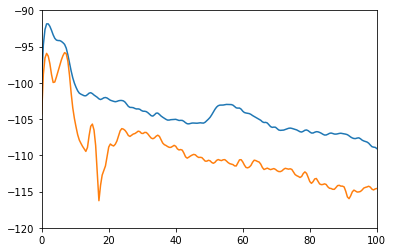

In [120]:
plt.plot(freq, power_in_db(csd_vstr1_vstr2))
plt.plot(freq, power_in_db(csd_vstr1_hipp))
plt.xlim(0, 100)
plt.ylim(-120, -90)

In [105]:
freq, csd = scipy.signal.csd(np_vstr1.data.T, np_vstr2.data.T, fs=fs, nperseg=window, nfft=int(window*2))

In [94]:
csd.shape

(115, 2049)

/home/emily/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


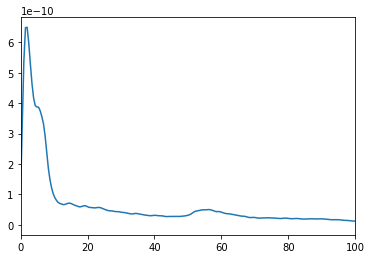

In [61]:
plt.plot(freq, np.squeeze(csd))
plt.xlim(0, 100)
plt.show()

In [ ]:
window = 2048
fs = 2000

vstr1 = np.squeeze(lfp_vstr1.data)
vstr2 = np.squeeze(lfp_vstr2.data)
hipp = np.squeeze(lfp_hipp.data)

fig, ax = plt.subplots()

# Theta
ax.axvspan(4, 12, color='#cccccc', alpha=0.3)
# Gamma
ax.axvspan(25, 100, color='#cccccc', alpha=0.3)

for lfp_data in [vstr1, vstr2, hipp]:
    power, freq = matplotlib.mlab.psd(lfp_data, 
                                      Fs=fs,
                                      NFFT=int(window*2),
                                      noverlap=int(window/2))

## Comparison of vStr-HC coherence between experimental conditions

Based on previous work 
(e.g. [van der Meer and Redish, 2011](http://www.jneurosci.org/content/31/8/2843.short?rss=1)) 
we might ask: is the coherence between hippocampus and ventral striatum modulated by task events? 
Here we will determine if there is a change in coherence between _approach to the reward site_
and _reward receipt_. 
This entails estimating the coherence spectrum for two different task epochs,
both aligned to the time at which the rat nosepoked in the reward well. 
FieldTrip is ideal for this, especially because we will be doing the same operations on multiple LFPs.

First, let's load the data. 
In your path shortcut, remember to add the FieldTrip path first, 
and then the lab codebase path, and also do a ''git pull''.

```matlab
cd('D:\data\R016\R016-2012-10-03'); 
LoadExpKeys;

cfg.fc = cat(2,ExpKeys.goodGamma(1:2),ExpKeys.goodTheta(1));
data = ft_read_neuralynx_interp(cfg.fc);
data.label = {'vStr1','vStr2','HC'};
```

We will segment the data into trials using a "trialfun", 
a function that conforms to a specific %%FieldTrip%% output format (see the 
[manual](http://www.fieldtriptoolbox.org/example/making_your_own_trialfun_for_conditional_trial_definition)) 
when extracting task-specific timestamps. 
For this data set (see the [paper](http://onlinelibrary.wiley.com/doi/10.1111/ejn.13069/full) for the details), 
the timestamps of interest are the times our subject (rat) noespoked into the reward receptacles, 
in anticipation of receiving a number of pellets. 

```matlab
%% trialify
data.hdr.Fs = data.fsample;

cfg = [];
cfg.trialfun = 'ft_trialfun_lineartracktone2';
cfg.trialdef.hdr = data.hdr;
cfg.trialdef.pre = 2.5; cfg.trialdef.post = 5; % define time window of interest
 
cfg.trialdef.eventtype = 'nosepoke'; % could be 'nosepoke', 'reward', 'cue'; this and what follows are all task-specific
cfg.trialdef.location = 'both'; % could be 'left', 'right', 'both'
cfg.trialdef.block = 'both'; % could be 'value', 'risk', 'both'
cfg.trialdef.cue = {'c1','c3','c5'}; % cell array with choice of elements {'c1','c3','c5','lo','hi'} (1, 3, 5 pellets; low and high risk)
 
[trl, event] = ft_trialfun_lineartracktone2(cfg);
cfg.trl = trl;
 
data_trl = ft_redefinetrial(cfg,data);
```

Next, we compute the trial-averaged cross-spectrum; 
note the similarity to the code used for computing spectrograms in a 
[previous module](analysis:course-w16:week7) 
-- we have changed ''cfg.output'' from 'pow' to 'powandcsd' 
(csd is for for cross-spectral density):

```matlab
cfg              = [];
cfg.output       = 'powandcsd';
cfg.method       = 'mtmconvol';
cfg.taper        = 'hanning';
cfg.foi          = 1:1:100; % frequencies to use
cfg.t_ftimwin    = 20./cfg.foi;  % frequency-dependent, 20 cycles per time window
cfg.keeptrials   = 'yes';
cfg.channel      = {'vStr1', 'vStr2', 'HC1'};
cfg.channelcmb   = {'vStr2', 'HC1'; 'vStr2', 'vStr1'}; % channel pairs to compute csd for

cfg.toi          = -2:0.05:0; % pre-nosepoke baseline (time 0 is time of nosepoke)

TFR_pre = ft_freqanalysis(cfg, data_trl);
```

Now we can compute the coherence from the cross-spectrum and the indvidual spectra:

```matlab
cfg            = [];
cfg.method     = 'coh'; % compute coherence; other measures of connectivity are also available
fd             = ft_connectivityanalysis(cfg,TFR_pre);
```

And finally plot the results -- for this we are bypassing ft's built-in plotter 
so that we can add some custom touches more easily:

```matlab
figure;
cols = 'rgb';
for iCmb = 1:size(fd.labelcmb,1)
    lbl{iCmb} = cat(2,fd.labelcmb{iCmb,1},'-',fd.labelcmb{iCmb,2});
      
    temp = nanmean(sq(fd.cohspctrm(iCmb,:,:)),2);
    h(iCmb) = plot(fd.freq,temp,cols(iCmb));
    hold on;
end
legend(h,lbl);
```

** The resulting coherence spectra are for the pre-nosepoke period 
(see ''cfg.toi'' in the frequency analysis step above).
Also compute the coherence spectrum for the post-nosepoke period (0 to 2 seconds). **

As you will see, a few differences in the HC-vStr coherence between the two windows are visible, 
such as the elevated 15Hz coherence during reward approach. 
To get a sense of where this may be coming from (artifact or biological? a single trial or reliable?)
it would be helpful to plot the raw LFPs aligned to the nosepoke time;
of course, more sessions would need to be analyzed as well to obtain errorbars on the data.

Notice that in our trial selection, we included trials on which 
1 food pellet, 3 food pellets, and 5 food pellets were all included together
(''cfg.trialdef.cue = {'c1','c3','c5'};'').

** Compare the coherence spectra for the 1-pellet and 5-pellet trials. What do you notice? **

# Time-frequency coherence analysis

A limitation of the coherence analyses up to this point has been that, 
like Welch's PSD, they have been averages. 
Just like the spectrogram provided a time-frequency view of signal power, 
we can attempt to compute a _coherogram_, coherence as a function of time and frequency. 

In fact, the previous steps in FieldTrip already did this, 
so we can plot it (note, this is the "post-nosepoke" epoch):

```matlab
iC = 1; % which signal pair to plot
lbl = [fd.labelcmb{1,:}]; % get the label of this pair
imagesc(fd.time,fd.freq,sq(fd.cohspctrm(iC,:,:))); axis xy; colorbar
xlabel('time (s)'); ylabel('Frequency (Hz)'); title(lbl);
```

You should get:

<img src="11-vstr_hc_cohereogram.png">

As you can see, the coherence at higher frequencies in particular looks very noisy. 
These "spurious" high coherence bins commonly show up when estimating coherence,
typically when one or both signals have little power in certain frequencies.

** Change the time window to a fixed 1s. 
How does the coherogram change? **

We can improve the robustness of our estimate by giving up some time resolution. 
Of course, averaging over more trials is another approach; 
other spectral estimation methods such as wavelets can also improve things 
(if you are interested in this, there is a nice MATLAB tutorial on wavelet coherence 
[here](http://www.mathworks.com/help/wavelet/examples/wavelet-coherence.html)).

# Beyond coherence

Coherence is only one of many measures that attempt to characterize the relationship between LFPs. 
A glance at the [documentation](http://fieldtrip.fcdonders.nl/reference/ft_connectivityanalysis)
for ''ft_connectivityanalysis()'' reveals a who's who of popular neuroscience tools 
for assessing functional connectivity.
A review of these methods is beyond the scope of this module, 
but in general they address some of the limitations of the coherence measure. 
For instance:

- Phase slope index (PSI), Granger causality, and partial directed coherence (PDC) are _directional_ measures 
that under certain circumstances can capture the direction of the flow of information between two signals. 
We will discuss a few of these in this module, below.
- Weighted phase lag index (WPLI) can exclude contributions from a volume-conducted source common to both signals
- Pairwise phase consistency (PPC) addresses some statistical issues 
of how coherence estimates are affected by the amount of data

For an illustration of how these improved methods 
can give a more reliable estimate of interactions than coherence, 
let's give pairwise phase consistency a try:

```matlab
cfg            = [];
cfg.method     = 'ppc';
fd             = ft_connectivityanalysis(cfg,TFR_post);
```

Plot the coherogram as above, changing ''cohspectrm'' to ''ppcspctrm'' in the plotting code. 
You should get (again for the post-nosepoke epoch):

<img src="11-vstr_hc_cohereogram2.png">

Note that some of the spurious high-frequency events have now been eliminated. 
In general, however, estimates of coherence and other connectivity measures
require relatively large amounts of data to obtain 
-- more than the small number of trials from one single session considered here.

# Amplitude cross-correlation

As should be clear from the discussion of coherence so far, 
it is a non-directional measure -- it doesn't address whether signal A leads or lags signal B. 
There are many methods out there that can be used to address this directionality question. 
One that you already have the tools to perform is computing the _amplitude cross-correlation_ between two signals,
filtered in a specific frequency band. 
Looking at the lower left panel in the figure at the top of the page, 
you can see that the amplitude envelope (red line) is clearly correlated between the two signals. 
Computing the cross-correlation would establish at what time lead (or lag) that correlation is maximal;
a peak offset from zero would indicate a specific temporal asymmetry suggesting one signal leads the other.

We will not cover this method in detail here 
since you already know how to compute amplitude envelopes and cross-correlations; 
however, if you'd like to delve more into this, example code that performs this analysis, 
including a very nice shuffling procedure to determine chance level, 
can be found on the vandermeerlab papers repository 
[here](https://github.com/mvdm/papers/blob/master/Catanese_vanderMeer2016/master/MASTER_AmplCorr.m). 
A recent paper introducing the method is 
[Adhikari et al. (2010)](http://www.sciencedirect.com/science/article/pii/S0165027010003432). 

# Granger causality: introduction

The concept of Granger causality 
([Granger 1969](http://www.jstor.org/stable/1912791?seq=1#page_scan_tab_contents)) is simple: 
if a signal $X$ "Granger-causes" signal $Y$, 
then knowing the value of $X$ improves your ability to predict $Y$ 
beyond what can be predicted from the history of $Y$ alone (see also 
[Seth 2007](http://www.scholarpedia.org/article/Granger_causality)). 
Thus, Granger-causality is inferred based on the relative fits of statistical models applied to time series data.

More mathematically:

$$
M_1: Y(t) = \sum_{l = 1}^{L} a_l Y(t-l) + \epsilon_1 \\ 
M_2: Y(t) = \sum_{l = 1}^{L} a'_l Y(t-l) + b'_l X(t-l) + \epsilon_2
$$

If $M_2$ provides a better fit to the data 
(best predicts the value of $Y(t)$) then $X$ is said to Granger-cause $Y$. 
The parameter $L$ indicates the number of samples into the past that are included in the model; 
as was the case in our discussion of [filters](analysis:course-w16:week6), 
the _order_ of the model refers to how many past samples are included (i.e. the value of $L$).

In general, the above models $M$ are examples of **autoregressive** (AR) models: 
the dependent variable $Y(t)$ is regressed against linear combinations of past values of that variable itself, 
where the coefficients $a$ and $b$ can be thought of as the regression coefficients or weights of each past value.
You may also encounter the term vector autoregressive (VAR) models, 
this is simply the multivariate extension of AR models. 
$M_2$ above is a VAR model since it has two variables. 
There is a large literature on (V)AR models, 
since it is a major tool in forecasting of all sorts of things ranging from the stock market to the weather.

# Generating artificial data

To explore how to fit AR models to data, 
it's a good idea to start with some artificial data of which we know the structure. 
Earlier in this module we did so "by hand", 
but here we will use FieldTrip's useful ''ft_connectivitysimulation()'':

```matlab
cfg             = [];
cfg.ntrials     = 1000;
cfg.triallength = 5; % in seconds
cfg.fsample     = 1000;
cfg.nsignal     = 2; % two signals, X and Y, which start out as identical white noise

cfg.method      = 'linear_mix';
cfg.mix         = [0; 0]; % multiply white noise for X and Y by this
cfg.delay       = [0; 0]; % Y is n samples delayed relative to X (both 0)
cfg.bpfilter    = 'no';
cfg.absnoise    = 1; % add independent noise to both signals, so now X and Y should be independent

data            = ft_connectivitysimulation(cfg);
data.label      = {'X','Y'};
```

The above code generates 1000 trials of 5 seconds each of independent white noise 
for two signals $X$ and $Y$. 
We do so in a somewhat roundabout way, 
by first setting the common signal in A and B to zero for each (''cfg.mix = [0; 0]'') 
and then adding independent noise of amplitude 1 to each (''cfg.absnoise = 1'').
Why this is so will become clear later when we generate more interesting combinations of signals.

** Verify that indeed the two signals X and Y are uncorrelated, 
as one would expect from independently generated white noise. 
One way to do so is to compute a correlation coefficient for each trial 
and plot the distribution of resulting correlation coefficients (use ''corrcoef()''). **

Next, we can fit our AR model:

```matlab
cfg_ar         = [];
cfg_ar.order   = 3;
cfg_ar.toolbox = 'bsmart';
mdata          = ft_mvaranalysis(cfg_ar, data);
```

Note the ''order'' parameter, which specifies how far back to estimate coefficients for 
(the $L$ parameter in the equations above). 
Although this is FieldTrip code, it uses the [BSMART](http://www.brain-smart.org/) toolbox 
under the hood to fit the model. 
The ''ft_mvaranalysis()'' function has some useful options we aren't using right now, 
such as the ability to estimate errorbars with the ''jackknife'' option. 
This takes a long time, however, so we don't do this now.

What we are interested in are the coefficients $a$ and $b$, 
i.e. the extent that we can predict each signal separately based on its own past, 
and then how much that prediction can be improved by knowledge of the other signal.

To plot these coefficients, we can do:

```matlab
figure; subplot(221)

labels = {'X->X','X->Y';'Y->X','Y->Y'}; cols = 'rgbc';
nP = 0;
for iI = 1:cfg.nsignal   
    for iJ = 1:cfg.nsignal
        nP = nP + 1;
    
        h(nP) = plot(1:cfg_ar.order,sq(mdata.coeffs(iI,iJ,:)),cols(nP));
        hold on;
        plot(1:cfg_ar.order,sq(mdata.coeffs(iI,iJ,:)),'.','MarkerSize',20,'Color',cols(nP));

    end
end
set(gca,'FontSize',18,'LineWidth',1); box off;
set(h,'LineWidth',2);
xlabel('lag (samples)'); ylabel('coefficient');
title('cfg.delay = [0; 0];');
legend(h,labels(:));
```

You should see that the coefficient values are very small (on the order of $10^{-4}$). 
This is what we expect from signals that we know to be uncorrelated; 
these values should not be statistically different from zero,
which would mean that we cannot predict anything about our signal based on its past 
-- the definition of white noise!

Let's now create some signals that do have some structure: 

```matlab
%%
cfg.mix         = [0.8; 0.8]; % X and Y are identical white noise with amplitude 0.8
cfg.absnoise    = 0.2; % add amplitude 0.2 *independent* noise
cfg.delay       = [0; 2]; % advance Y 2 samples relative to X

data            = ft_connectivitysimulation(cfg);
data.label      = {'X','Y'};
```

** Fit the VAR model again, and plot the coefficients in the next subplot. **

You should get something like:

<img src="11-var-model.png">

Note how for the delay case, we correctly estimate that X can be predicted from Y, 
at the expected delay of 2 samples.

It is important to be aware of the limitations of Granger causality. 
The term "Granger-causes" is often used to indicate the inherently descriptive nature of VAR models, 
which cannot distinguish true causality from a number of alternative scenarios. 
Prominent among these is the possibility of a common input Z affecting both X and Y, 
but with different time lags. 
X may then "Granger-cause" Y, without any direct anatomical connection between them.
A different, all-too common case is when signals X and Y have different signal-to-noise ratios; 
we will highlight this issue in the next section. 
More generally, it is unclear what conclusions can be drawn from Granger causality 
in systems that with recurrent (feedback) connections,
which are of course ubiquitous in the brain -- a nice paper demonstrating and discussing this is
[Kispersky et al. 2011](http://neuralsystemsandcircuits.biomedcentral.com/articles/10.1186/2042-1001-1-9).

# Spectrally resolved Granger causality

Given how ubiquitous oscillations are in neural data, 
it is often informative to not fit VAR models directly in the time domain 
(as we did in the previous section) but go to the frequency domain. 
Intuitively, _spectrally resolved_ Granger causality measures how much of the power in $X$, 
not accounted for by $X$ itself, can be attributed to $Y$ 
([technical paper](http://www.sciencedirect.com/science/article/pii/S1053811908001328)). 
To explore this, we'll generate some more artificial data:

```matlab
nTrials = 1000;

cfg             = [];
cfg.ntrials     = nTrials;
cfg.triallength = 5;
cfg.fsample     = 1000;
cfg.nsignal     = 2;

cfg.method      = 'linear_mix';
cfg.mix         = [0.5; 0.5];
cfg.delay       = [0; 4];
cfg.bpfilter    = 'yes';
cfg.bpfreq      = [50 100]; % white noise gets filtered in this frequency band
cfg.absnoise    = 0.5; % add independent noise to both signals

data            = ft_connectivitysimulation(cfg);
data.label      = {'X','Y'};
```

Note that we are now using the ''bpfilter'' cfg option, 
which filters the original white noise in the specified frequency band. 
Thus, X and Y are 50% identical signal with frequency content between 50 and 100 Hz,
and 50% independent noise.
(You can inspect what this looks like by doing ''ft_databrowser([],data)'').

Next, we perform the frequency decomposition, FieldTrip-style:

```matlab
cfg_TFR = [];
cfg_TFR.channel = {'X','Y'};
cfg_TFR.channelcmb = {'X' 'Y'};
cfg_TFR.method = 'mtmfft';
cfg_TFR.output = 'fourier';
cfg_TFR.foi = 1:1:150;
cfg_TFR.taper = 'hanning';

TFR = ft_freqanalysis(cfg_TFR,data);
```

Now we can compute the Granger spectra:

```matlab
cfg_G = [];
cfg_G.method = 'granger';
cfg_G.channel = {'X','Y'};
cfg_G.channelcmb = {'X' 'Y'};

C = ft_connectivityanalysis(cfg_G,TFR);
```

...and plot the results:

```matlab
figure;
for iP = 1:4
    subplot(2,2,iP);
    plot(C.freq,C.grangerspctrm(iP,:));
    set(gca,'FontSize',14,'YLim',[0 0.5]);
    title([C.labelcmb{iP,:}]);
end
```

You should get something like

<img src="11-granger-spectral.png">

These panels show how much of the power in X (or Y) 
can be predicted based on itself, or the other signal. 
You can see that the top right panel (Y→X) has higher coefficients than the reverse (X→Y),
consistent with the 4-sample advancement of Y relative to X.

** Why are there non-zero coefficients for the X→Y direction? 
Test your hypothesis with artificial data. **

Now, let's consider the following case:

```matlab
cfg             = [];
cfg.ntrials     = nTrials;
cfg.triallength = 5;
cfg.fsample     = 1000;
cfg.nsignal     = 2;

cfg.method      = 'linear_mix';
cfg.mix         = [1; 0.5]; % X bigger than Y
cfg.delay       = [0; 0];
cfg.bpfilter    = 'yes';
cfg.bpfreq      = [50 100]; % white noise gets filtered in this frequency band
cfg.absnoise    = 0.5; % add independent noise to both signals

data            = ft_connectivitysimulation(cfg);
data.label      = {'X','Y'};
```

Note that $X$ is the same signal as $Y$, but twice as large; 
there is _no delay_ between them. 
Independent noise is then added to both $X$ and $Y$ as before.

** Compute the Granger cross-spectra for these signals as was done above. **

You should see that X Granger-causes Y.

** How is this possible, given that we generated X and Y to have zero delay? **

This case, in which two (near-)identical signals have different signal-to-noise ratios, 
is very common in neuroscience. 
As you have seen, Granger causality can be easily fooled by this.

How can we detect if we are dealing with a Granger-causality false positive like this? 
An elegant way is to _reverse_ both signals and test again; 
if the Granger asymmetry persists after this, we have a tell-tale of a signal-to-noise Granger artifact.

Reverse the two signals and compute Granger cross-spectra, 
both for the zero-delay artifact case and for the true causal case above. 
Verify that this reverse-Granger test accurately distinguishes the two cases. 
[This paper](http://www.sciencedirect.com/science/article/pii/S105381191401009X) 
discusses these issues in more detail and has thoughtful discussion.

# Phase-slope index

If we have a situation such as the above, 
it is possible that a true lag or lead between two signals is obscured by different signal-to-noise ratios. 
If such a case is detected by the reverse-Granger analysis, 
how can we proceed with identifying the true delay?

A possible solution is offered by the analysis of **phase slopes**: 
the idea that for a given lead or lag between two signals, 
the phase lag (or lead) should systematically depend on frequency 
([Nolte et al. (2008)](http://arxiv.org/pdf/0712.2352.pdf), 
see also precedents in the literature such as 
[Schoffelen et al. (2005)](http://science.sciencemag.org/content/308/5718/111.short)).

[Catanese and van der Meer (2016)](https://github.com/mvdm/papers/tree/master/Catanese_vanderMeer2016)
diagram the idea as follows:

<img src="11-phase-slope_index.png">

In the example in (**A**) above, the red signal always leads the blue signal by 5 ms, 
which results in a different phase lag across frequencies (20, 25 and 33.3 Hz in this example).
This is because 5ms is a much bigger slice of a full oscillation cycle at 33.3Hz than it is at 25Hz; 
the bottom panel shows the linear relationship between phase lag and frequency for the above examples, 
resulting in a positive slope for the red-blue phase difference indicating a red signal lead.

(**B**) shows the raw phase differences for an example real data session in the top panel: 
note that the phase lag as a function of frequency contains 
approximately linear regions in the "low-gamma" (45-65 Hz, green) and "high-gamma" (70-90 Hz, red) frequency bands,
with slopes in opposite directions. 
The phase slope (middle panel) is the derivative of the raw phase lag, 
and the reversal of the phase slope sign around 65-70 Hz indicates that high and low gamma 
are associated with opposite directionality in the vStr-mPFC system, 
with vStr leading for low gamma and mPFC leading for high gamma oscillations. 
The bottom panel shows the phase slope index (PSI) which normalizes the raw phase slope by its standard deviation.

Thus, to summarize, the phase slope index (PSI) is a normalized form of the phase slope 
-- obtained by dividing the raw phase slope at each frequency by its standard deviation 
(estimated using a bootstrap). 
The phase slope itself is obtained by taking the derivative (slope) 
of the raw phase differences across frequencies;
as discussed above, these raw phase differences can be obtained by 
estimating the phase (angle) of the cross-spectrum.

The time lag (or lead) between two signals given a phase slope is:

$$
t_{a-b} = [\frac{\phi_{a-b}(f+df) - \phi_{a-b}(f)}{df}]/ 360^{\circ}
$$

where $t_{a-b}$ is the time lag (or lead) in seconds between signals $a$ and $b$, 
to be inferred from the phase differences $\phi_{a-b}$ (in degrees) 
observed at frequencies $f$ and $f+df$. 
For instance, given a phase difference $\phi_{a-b} = 45^{\circ}$ between signals $a$ and $b$ at $f = 25$Hz, 
and $\phi_{a-b} = 36^{\circ}$ at $f = 20$Hz, $t_{a-b} = [(45-36)/(25-20)]/360 = 5$ms 
(the example in panel **A** above). 
As $df \to 0$, the fraction shown in square brackets above corresponds to the derivative $\phi_{a-b}'(f)$, 
i.e. the phase slope. Positive time lags indicate that $a$ leads $b$.

To test how this works, let's generate two signals with an ambiguous Granger-relationship:

```matlab
nTrials = 1000;

cfg             = [];
cfg.ntrials     = nTrials;
cfg.triallength = 5;
cfg.fsample     = 1000;
cfg.nsignal     = 2;

cfg.method      = 'linear_mix';
cfg.mix         = [1; 0.3]; % X bigger than Y
cfg.delay       = [0; 4];
cfg.bpfilter    = 'yes';
cfg.bpfreq      = [50 100]; % white noise gets filtered in low gamma band
cfg.absnoise    = 0.5; % add independent noise to both signals

data            = ft_connectivitysimulation(cfg);
data.label      = {'X','Y'};
```

Note that Y leads X, but X has larger amplitude than Y.

** Verify that according to the Granger spectra, 
there is no evidence to support an asymemtric (Granger-causal) relationship between Y and X. 
Since we generated the signals with a 4 sample lead for Y, we know this to be incorrect. **

Now, let's compute the phase slope. 
We start with the Fourier decomposition, as before:

```matlab
cfg_TFR = [];
cfg_TFR.channel = {'X','Y'};
cfg_TFR.channelcmb = {'X' 'Y'};
cfg_TFR.method = 'mtmfft';
cfg_TFR.output = 'fourier';
cfg_TFR.foi = 1:1:150;
cfg_TFR.taper = 'hanning';

TFR = ft_freqanalysis(cfg_TFR,data);
```

But now, we use a different method for the connectivity analysis:

```matlab
cfg_psi = [];
cfg_psi.method = 'psi';
cfg_psi.bandwidth = 8; % number of frequencies to compute slope over
cfg_psi.channel = {'X','Y'};
cfg_psi.channelcmb = {'X' 'Y'};

C = ft_connectivityanalysis(cfg_psi,TFR);
```

We plot the phase slope between Y and X:

```matlab
figure;
plot(C.freq,sq(C.psispctrm(2,1,:)));
xlabel('Frequency'); ylabel('Phase slope');
```

The positive phase slope correctly identified that Y leads X.

** What are the units on the vertical axis? **